In [1]:
# data vis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np # math

from datetime import datetime         # convert datetime
import scipy.stats as stats           # correlation

# link to dataset
dataset = 'Assignment2_Dataset.csv'

# INIT SEED
SEED = 2202934

In [2]:
# load df with dataset
df = pd.read_csv(dataset, encoding='cp1252', parse_dates=['Date'], dayfirst=False, index_col='S/N') 
# S/N will be index since it's the ID for each record (unique for each row)

In [3]:
# Remove duplicated rows
df.drop([3533, 2610, 8385], inplace=True)

In [4]:
df = df[(df['Rented_Bike_Count'] != -2) & (df['Rented_Bike_Count'] != 34180.0)]

In [5]:
df = df.dropna(subset=['Rented_Bike_Count'])

In [6]:
# fill missing values in Hour using linear interpolation since it is in time-series
df['Hour'].interpolate(method='linear', inplace=True)

In [7]:
df['Temperature'].interpolate(method='quadratic', inplace=True)
df['Temperature'] = df['Temperature'].round(decimals=1) # Round off the interpolated values to one decimal place

In [8]:
df = df[(df['Temperature'] >= -41) & (df['Temperature'] <= 41)]

In [9]:
def calculate_humidity(temperature, dew_point):
    # formula
    numerator = np.exp((17.625 * dew_point) / (243.04 + dew_point))
    denominator = np.exp((17.625 * temperature) / (243.04 + temperature))
    relative_humidity = 100 * (numerator / denominator)
    
    # round to nearest whole number
    return np.round(relative_humidity)


# ONLY impute rows with missing Humidity
df.loc[df['Humidity'].isnull(), 'Humidity'] = calculate_humidity(df['Temperature'], df['Dewpoint_Temp'])

In [10]:
df = df[df['Humidity'] != 0]

In [11]:
df['Snowfall'].fillna('no_snowfall', inplace=True)

In [12]:
df = df.dropna(subset=['Hit_Sales'])

In [13]:
# Replace 'N' with 'No'
df['Open'] = df['Open'].replace('n', 'No')

# Normalize Yes for consistency
df['Open'] = df['Open'].replace(['Y', 'yes', 'yes '], 'Yes')

In [14]:
# Converting Snowfall to ordinal
df['Snowfall'] = df['Snowfall'].replace({'no_snowfall': 0, 'low': 1, 'medium': 2, 'heavy': 3, 'very heavy': 4})

# Encoding Hit_Sales to Binary
df['Hit_Sales'] = df['Hit_Sales'].replace({'N': 0, 'Y': 1})

# Encoding Open to Binary
df['Open'] = df['Open'].replace({'No': 0, 'Yes': 1})

In [15]:
# Define the bin ranges and interpretive labels for each attribute
bin_ranges = {
    'Rented_Bike_Count': [-1, 0, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500],
    'Temperature': [-30, -20, -10, 0, 10, 20, 30, 41],
    'Windspeed': [-1, 0.9, 2, 3, 5, 7.5],
    'Dewpoint_Temp': [-40, -20, 0, 20, 41],
    'Solar_Radiation': [-1, 0.01, 0.5, 1, 2, 4],
    'Rainfall': [-1, 5, 10, 20, 30, 36]
}

interpretive_labels = {
    'Rented_Bike_Count': ['No rentals', '1-100', '101-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501-3000', '3001-3500'],
    'Temperature': ['-30 to -20', '-20 to -10', '-10 to 0', '0 to 10', '10 to 20', '20 to 30', '30+'],
    'Windspeed': ['0-0.9', '0.9-2', '2-3', '3-5', '5+'],
    'Dewpoint_Temp': ['<-20', '-20 to 0', '0 to 20', '20+'],
    'Solar_Radiation': ['0', '0.01-0.5', '0.5-1', '1-2', '2+'],
    'Rainfall': ['No rain', '5-10', '10-20', '20-30', '30+']
}

# Perform binning and label assignment for each attribute
for attribute, bins in bin_ranges.items():
    df[f'{attribute}_Bins'] = pd.cut(df[attribute], bins=bins, labels=interpretive_labels[attribute])

In [16]:
def comfortScale(row):
    score = 0
    
    if row['Temperature'] >= 20 and row['Temperature'] <= 30:
        score += 1
        
    if row['Humidity'] >= 30 and row['Humidity'] <= 60:
        score += 1
    
    if row['Windspeed'] <= 3:
        score += 1
    
    if row['Visibility'] <= 3:
        score += 1
    
    if row['Rainfall'] == 0:
        score += 1
        
    return score

df['Comfort_Scale'] = df.apply(comfortScale, axis=1)

In [17]:
# Create new Columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Map month numbers to month names
month_mapping = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df['Month'] = df['Month'].map(month_mapping)
df['Day'] = df['Date'].dt.day_name()

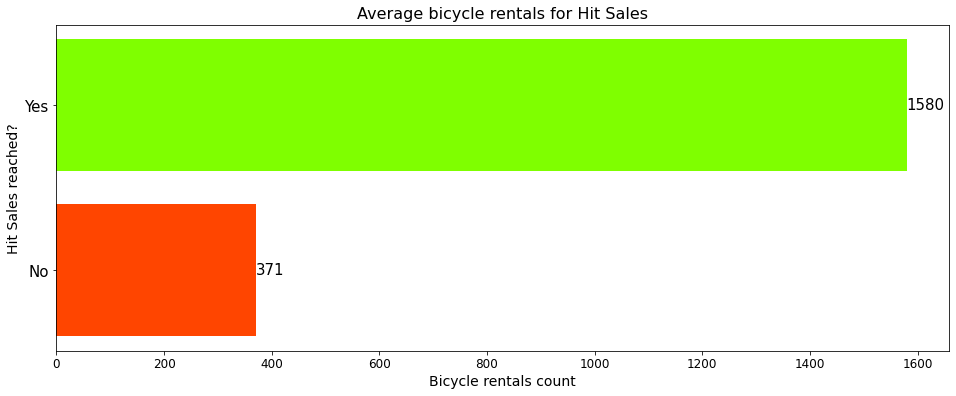

In [18]:
# Groupby hit_sales, and find the mean rented_bike_count for Yes and No
average_rented_count = df.groupby('Hit_Sales')['Rented_Bike_Count'].mean()

plt.figure(figsize=(16, 6))
plt.barh(['No', 'Yes'], average_rented_count.values, color=['orangered', 'chartreuse']) # label y-axis with accurate names

plt.title('Average bicycle rentals for Hit Sales', fontsize=16)
plt.xlabel('Bicycle rentals count', fontsize=14)
plt.ylabel('Hit Sales reached?', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)

# Add count at the end of each bar
for i, v in enumerate(average_rented_count.values):
    plt.text(v, i, str(round(v)), fontsize=15, va='center')

plt.show()

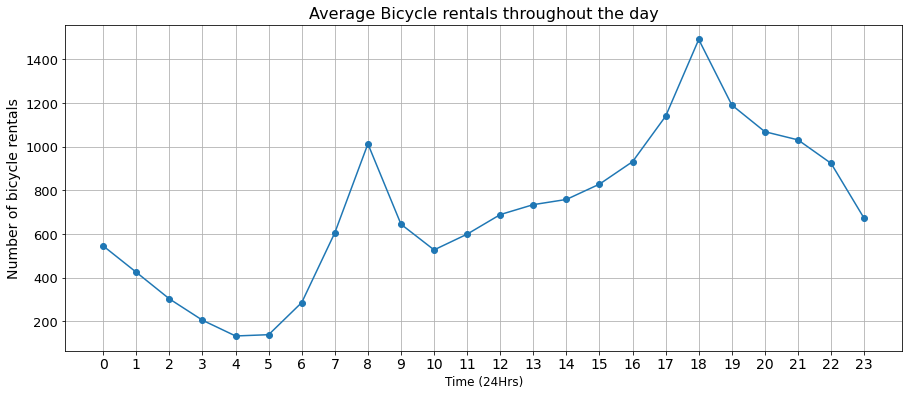

In [19]:
# Group by hour and calculate the average rented bike count
hourly_rentals = df.groupby('Hour')['Rented_Bike_Count'].mean()
plt.figure(figsize=(15, 6))

plt.plot(hourly_rentals.index, hourly_rentals.values, marker='o')
plt.title('Average Bicycle rentals throughout the day', fontsize=16)

plt.xlabel('Time (24Hrs)', fontsize=12)
plt.ylabel('Number of bicycle rentals', fontsize=14)
plt.xticks(hourly_rentals.index, fontsize=14)
plt.yticks(fontsize=13)

plt.grid(True)  # Add a grid
plt.show()

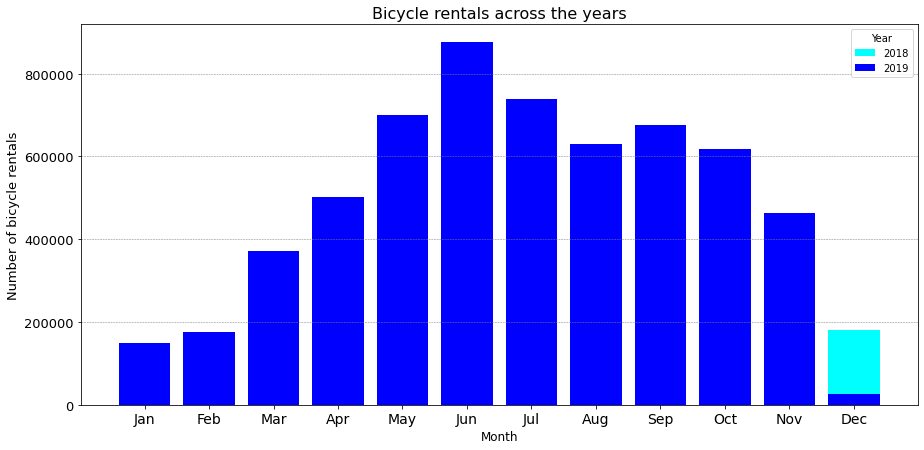

In [20]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

yearly_monthly_rentals = df.groupby(['Year', 'Month'])['Rented_Bike_Count'].sum()
plt.figure(figsize=(15, 7))

# Creating a separate bar for each month and differentiating by year
for year in yearly_monthly_rentals.index.get_level_values('Year').unique():
    monthly_rentals = yearly_monthly_rentals[year]
    
    # Set color for each year
    if year == 2018:
        color = 'cyan'
    elif year == 2019:
        color = 'blue'
    
    plt.bar(month_order, monthly_rentals.reindex(month_order), label=str(year), color=color)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of bicycle rentals', fontsize=13)
plt.title('Bicycle rentals across the years', fontsize=16)
plt.legend(title='Year')
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)

plt.gca().yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.show()

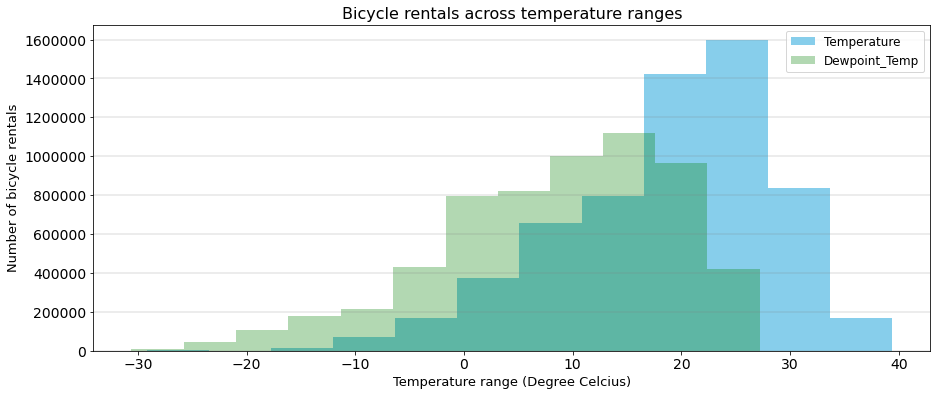

In [21]:
plt.figure(figsize=(15, 6))

df.Temperature.plot(kind='hist', weights=df['Rented_Bike_Count'], color='skyblue', bins=12)
df.Dewpoint_Temp.plot(kind='hist', weights=df['Rented_Bike_Count'], color='green', bins=12, alpha=0.3)
plt.title('Bicycle rentals across temperature ranges', fontsize=16)

plt.xlabel('Temperature range (Degree Celcius)', fontsize=13)
plt.ylabel('Number of bicycle rentals', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=12)
plt.gca().yaxis.set_major_formatter('{:.0f}'.format) # scale y-axis units to normal interpretation for easier understanding

plt.gca().yaxis.grid(True, linewidth=0.3, color='gray')
plt.show()

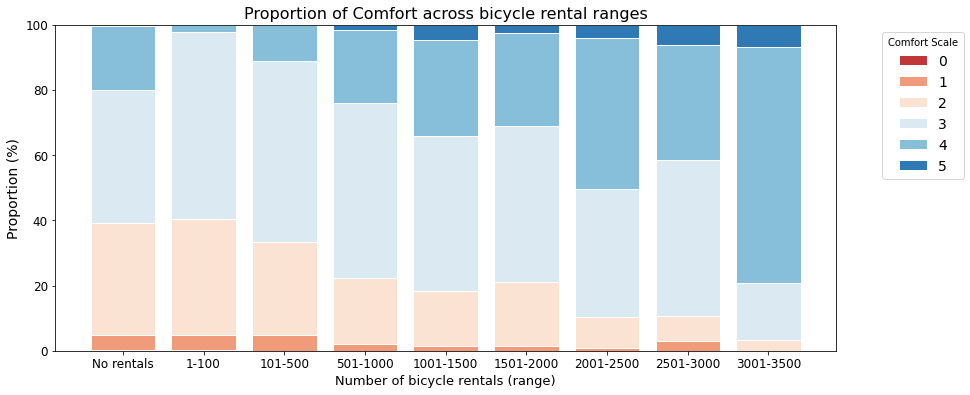

In [22]:
plt.figure(figsize=(14, 6))

grouped_data = df.groupby(['Rented_Bike_Count_Bins', 'Comfort_Scale'])['Rented_Bike_Count'].count().unstack()
grouped_data = grouped_data.apply(lambda x: (x / x.sum()) * 100, axis=1)   # Normalize the counts to proportions out of 100%

x = np.arange(len(grouped_data.index))      # enumerating x-axis
bottom = np.zeros(len(grouped_data.index))  # enumerating y-axis

color_scheme = sns.color_palette("RdBu", 6)

# Plot each stacked column with custom color
for i, comfort_scale in enumerate(grouped_data.columns):
    values = grouped_data[comfort_scale]
    plt.bar(x, values, width=0.8, bottom=bottom, edgecolor='white', label=comfort_scale, color=color_scheme[comfort_scale])
    bottom += values

plt.xlabel('Number of bicycle rentals (range)', fontsize=13)
plt.ylabel('Proportion (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Proportion of Comfort across bicycle rental ranges', fontsize=16)

plt.legend(title='Comfort Scale', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

plt.xticks(x, grouped_data.index, fontsize=12)  # Set the x-axis labels to the bin labels
plt.show()

In [23]:
df = df[df['Rented_Bike_Count'] > 0]

In [24]:
months = [['Dec', 'Jan', 'Feb'], ['Mar', 'Nov', 'Apr'], ['Oct', 'Aug', 'Sep', 'May', 'Jul'], 'Jun']
# Worst performing Month -> Best performing Month

month_to_encoded = {}
encoded_month = 1

for month in months:
    if isinstance(month, list):
        for m in month:
            month_to_encoded[m] = encoded_month
        encoded_month += 1
    else:
        month_to_encoded[month] = encoded_month
        encoded_month += 1

df['Encoded_Month'] = df['Month'].map(month_to_encoded)

In [25]:
hours = [[4,5], [0,1,2,3], [6,7], [10,11], 9, [12,13], [14,15,16], [20,21,22,23], 8, [17, 18, 19]]
# 4-5AM, 12PM-3AM, 6-7AM, 10AM-11AM, 9AM, 12AM-1PM, 2-4PM, 8PM-11PM, 8AM, 5PM-7PM

# Create a dictionary to map the hours to their encoded values
hour_to_encoded = {}
encoded_hour = 0 # start from 0 since 4-5AM demand is significantly lower than other hours

for hour in hours:
    if isinstance(hour, list):
        for h in hour:
            hour_to_encoded[h] = encoded_hour
        encoded_hour += 1
    else:
        hour_to_encoded[hour] = encoded_hour
        encoded_hour += 1

df['Encoded_Hour'] = df['Hour'].map(hour_to_encoded) # Use the dictionary to create the 'Encoded_Hour' column in the DataFrame

In [26]:
FEATURES = ['Temperature', 'Humidity', 'Solar_Radiation', 'Rainfall', 'Encoded_Hour', 'Encoded_Month', 'Comfort_Scale']
HIT_SALES = ['Hit_Sales']       # classification
BIKE = ['Rented_Bike_Count']    # regression

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
from sklearn.neighbors import KNeighborsRegressor
Y = df[BIKE]               # set target
X = df[FEATURES]           # set x predictors

# 1. DON'T SCALE PREDICTORS
# so that model recognizes the original values for prediction

# 2. Partition data 80% : 20%
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, \
                                                  shuffle=True, random_state=SEED)

# Building Model
knn_model = KNeighborsRegressor(n_neighbors=5)   # trial and error to obtain best performing n
knn_model.fit(X_train, Y_train)                  # Train model using training set

KNeighborsRegressor()

In [29]:
RF_FEATURES = ['Temperature', 'Encoded_Hour', 'Humidity', 'Solar_Radiation', 'Encoded_Month', 'Rainfall', 'Comfort_Scale']
Y = df[HIT_SALES]               # set target
X = df[RF_FEATURES]             # set x predictors

# 1. DON'T SCALE PREDICTORS
# so that model recognizes the original form for prediction

# 2. Partition data 80% : 20%
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, \
                                                  shuffle=True, random_state=SEED)

# Ravel to make y a 1-dimensional array
Y_train = Y_train.values.ravel()

# 3. Building model
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
random_forest_model.fit(X_train, Y_train) # train model

RandomForestClassifier(random_state=2202934)

In [30]:
def predictiveModels():
    print("Predict Sales Performance")
    
    # Get input values from the user
    Temperature = float(input("Temperature (Degree Celcius): "))
    Humidity = float(input("Humidity (%): "))
    Solar_Radiation = float(input("Solar Radiation (MJ/m^2): "))
    Rainfall = float(input("Rainfall (mm): "))
    Hour = int(input("Time (24Hour format): "))
    
    while True:
        Month = input("Month (first 3 letters): ").lower()
        Month = Month[0:3] # sanitize
        
        if Month not in ['dec', 'jan', 'feb', 'mar', 'nov', 'apr', 'oct', 'aug', 'sep', 'may', 'jul', 'jun']:
            print('Invalid Month')
        else:
            break

    Windspeed = input("Is it windy? (Y/N): ").lower()
    Windspeed = Windspeed[0:1]
    Visibility = input("Is weather expected to be clear (Y/N): ").lower()
    Visibility = Visibility[0:1]

    # calculating comfort scale
    Comfort_Scale = 0

    if Temperature >= 20 and Temperature <= 30:
        Comfort_Scale += 1

    if Humidity >= 30 and Humidity <= 60:
        Comfort_Scale += 1

    if Windspeed == 'n':
        Comfort_Scale += 1

    if Visibility == 'y':
        Comfort_Scale += 1

    if Rainfall == 0:
        Comfort_Scale += 1
        
        
    # ranking month
    months = [['dec', 'jan', 'feb'], ['mar', 'nov', 'apr'], ['oct', 'aug', 'sep', 'may', 'jul'], 'jun']
    month_to_encoded = {}
    encoded_month = 1

    for month in months:
        if isinstance(month, list):
            for m in month:
                month_to_encoded[m] = encoded_month
            encoded_month += 1
        else:
            month_to_encoded[month] = encoded_month
            encoded_month += 1
            
    Encoded_Month = month_to_encoded.get(Month, -1)
    
    
    # ranking hour
    hours = [[4,5], [0,1,2,3], [6,7], [10,11], 9, [12,13], [14,15,16], [20,21,22,23], 8, [17, 18, 19]]
    hour_to_encoded = {}
    encoded_hour = 0

    for hour in hours:
        if isinstance(hour, list):
            for h in hour:
                hour_to_encoded[h] = encoded_hour
            encoded_hour += 1
        else:
            hour_to_encoded[hour] = encoded_hour
            encoded_hour += 1

    Encoded_Hour = hour_to_encoded.get(Hour, -1)
    

    # formatting parameters for models
    knn_data = pd.DataFrame({
        'Temperature': [Temperature],
        'Humidity': [Humidity],
        'Solar_Radiation': [Solar_Radiation],
        'Rainfall': [Rainfall],
        'Encoded_Hour': [Encoded_Hour],
        'Encoded_Month': [Encoded_Month],
        'Comfort_Scale': [Comfort_Scale]
    })
    
    rf_data = pd.DataFrame({
        'Temperature': [Temperature], 
        'Encoded_Hour': [Encoded_Hour],
        'Humidity': [Humidity],
        'Solar_Radiation': [Solar_Radiation],
        'Encoded_Month': [Encoded_Month],
        'Rainfall': [Rainfall],
        'Comfort_Scale': [Comfort_Scale]
    })


    knn_prediction = knn_model.predict(knn_data)
    rf_prediction = random_forest_model.predict(rf_data)

    print()
    print("Based on Model:")
    print(f"You should expect around {knn_prediction[0]} bicycle rentals.")
    print(f"Hit sales is {['EXPECTED' if rf_prediction == 1 else 'NOT EXPECTED'][0]} to be achieved.")

In [31]:
predictiveModels()

Predict Sales Performance
Temperature (Degree Celcius): 33.1
Humidity (%): 59
Solar Radiation (MJ/m^2): .72
Rainfall (mm): 0
Time (24Hour format): 18
Month (first 3 letters): aug
Is it windy? (Y/N): y
Is weather expected to be clear (Y/N): y

Based on Model:
You should expect around [2065.] bicycle rentals.
Hit sales is EXPECTED to be achieved.
